# The HFM library - A fast marching solver with adaptive stencils

## Part : Seismology
## Chapter : Metrics arising in seismic travel time tomography

In this notebook, we demonstrate anisotropic fast marching with a class of metrics arising in seismic travel time tomography. They characterize the first arrival time of seismic P-waves (compressive waves), in the high frequency asymptotic. The seismic models are implemented in dimension $d \in \{2,3\}$. <!---  (the two dimensional instance being mostly for testing purposes)-->

The eikonal equation reads
$$
    \det(m_x(\nabla u) - \rho(x){\rm Id}) = 0,
$$
where for each co-vector $p$ one defines
$$
    m_x(p)_{ij} = \sum_{k,l} c_{ijkl}(x) p_k p_l.
$$
We denoted by $c(x) = (c_{ijkl}(x))$, where $i,j,k,l \in \{1,\cdots,d\}$ the Hooke tensor, which describes the elastic properties of the geological medium. The user must take care to only provide elliptic (or positive) Hooke tensors. This assumption, satisfied in physical contexts, ensures that $m=m(v)$ is positive definite as soon as $v\neq 0$. 

The Hooke tensor must be given in Voigt notation. We use the following conventions, which may be relaxed in the future: <!-- This should be in the c++ code --> 
* No normalization of the coefficients by $\sqrt 2$, which is often found in the literature.
* The provided tensor should be $c/\rho$, accounting for the density of the medium. <!-- The medium density $\rho$ is positive. -->
* The same grid scale is used on each axis.

**Accuracy:**
Our implementation of the fast marching method for seismic metrics is designed to achieve high accuracy, up to third order, in smooth test cases. However this capability is not demonstrated in the present notebook, but in [C1 Achieving high accuracy](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/Aa_HighAccuracy.ipynb)

**Work in progress**
The experiments presented in this notebook are part of the internship of François Desquilbet [link](https://www.see.asso.fr/en/distinction/24512_prix-jeunes-national-andre-blanc-lapierre-2018-trophee-ile-france).
Tutors : J.-M. Mirebeau (CNRS, U. PSud, U. PSaclay), L. Métivier (CNRS, LJK, ISTerre, Univ Grenoble, France) [link](https://www-ljk.imag.fr/membres/Ludovic.Metivier/)

**References** 
The main techniques used are presented in the following publication.

Mirebeau, J.-M. (2014). Efficient fast marching with Finsler metrics. Numerische Mathematik, 126(3), 515–557. [link](https://hal.archives-ouvertes.fr/hal-00736431)


In [6]:
import sys; sys.path.append("..") # Allow imports from parent directory
from Miscellaneous import TocTools; TocTools.displayTOC('Seismic','FMM')

[**Summary**](Summary.ipynb) of this series of notebooks. 

[**Main summary**](../Summary.ipynb), including the other volumes of this work. 


# Table of contents

  * [1. A constant medium, with tilted and anelliptic anisotropy](#1.-A-constant-medium,-with-tilted-and-anelliptic-anisotropy)
  * [2. Varying medium](#2.-Varying-medium)
    * [2.1 Position dependent tilt orientation.](#2.1-Position-dependent-tilt-orientation.)
    * [2.2 Piecewise constant medium](#2.2-Piecewise-constant-medium)
  * [3. Taking into account the topography](#3.-Taking-into-account-the-topography)
  * [4. Testing reproduction](#4.-Testing-reproduction)
    * [4.1 Case of a constant metric](#4.1-Case-of-a-constant-metric)
    * [4.2 Case with topography](#4.2-Case-with-topography)
  * [4. Three dimensional example](#4.-Three-dimensional-example)
    * [4.1 Case of a constant metric](#4.1-Case-of-a-constant-metric)
    * [4.2 Position dependent metric](#4.2-Position-dependent-metric)
    * [4.3 Topography](#4.3-Topography)




This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay


## 0. Importing the required libraries

In [7]:
import HFMUtils
from NumericalSchemes import LinearParallel as lp

In [8]:
from HFMUtils.Seismic import Hooke2, Hooke3

In [9]:
import numpy as np
import scipy.linalg
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
figSaveDir = 'Images/Seismic/'

## 1. A constant medium, with tilted and anelliptic anisotropy

The Hooke tensors and densities of a a small number of geophysical media are provided. 
Here we construct three tensors corresponding to the slice, tilted, of uniform media.

In [11]:
hooke1 = Hooke2.Rotate(Hooke2.ExtractXZ(Hooke3.Mica / Hooke3.Mica_rho),np.pi/6)
hooke2 = Hooke2.Rotate(Hooke2.ExtractXZ(Hooke3.Stishovite / Hooke3.Stishovite_rho),-np.pi/8)
hooke3 = Hooke2.Rotate(Hooke2.ExtractXZ(Hooke3.Olivine / Hooke3.Olivine_rho),np.pi/12)

In [12]:
# Flatten symmetric matrix for input to the c++ code
hooke = HFMUtils.FlattenSymmetricMatrix(hooke1)

In [13]:
hfmIn_Constant = {
    'model':'Seismic2',
    'arrayOrdering':'YXZ_RowMajor',
    'exportValues':1,
    'seeds':[[0.,0.]],
    'tips':[[x,y] for y in HFMUtils.CenteredLinspace(-1,1,6) 
                    for x in HFMUtils.CenteredLinspace(-1,1,6)],
    'metric':hooke,
    'stencilGeometry':'Square', # Alternatively, use a non-adaptive stencil
    'exportGeodesicFlow':1,
}

# Define the domain
n=201
hfmIn_Constant.update(HFMUtils.Rect(sides=[[-1,1],[-1,1]],dimx=n))

X,Z = HFMUtils.GetGrid(hfmIn_Constant)

In [14]:
hfmOut = HFMUtils.Run(hfmIn_Constant)

In [15]:
hfmOut['FMCPUTime'], hfmOut['StencilCPUTime']

(0.214478, 0.000232)

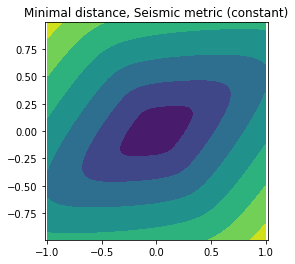

In [16]:
fig = plt.figure(figsize=[4,4]); plt.title('Minimal distance, Seismic metric (constant)'); plt.axis('equal')
plt.contourf(X,Z,hfmOut['values']);

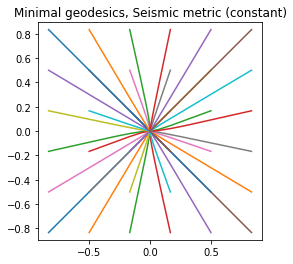

In [17]:
# The geodesics are straight lines, since the metric is constant
fig = plt.figure(figsize=[4,4]); plt.title('Minimal geodesics, Seismic metric (constant)'); plt.axis('equal'); 
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 

Presently, the returned geodesic flow is not normalized (only the direction is informative). 

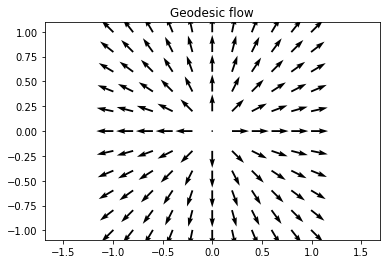

In [18]:
plt.title("Geodesic flow"); plt.axis('equal')
flow = hfmOut['geodesicFlow']
flowNorm = np.linalg.norm(flow,axis=2)+1e-9; flow[:,:,0]/=flowNorm; flow[:,:,1]/=flowNorm;
s=20; plt.quiver(X[::s,::s],Z[::s,::s],flow[::s,::s,0],flow[::s,::s,1]);

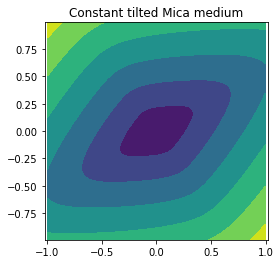

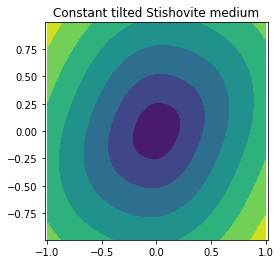

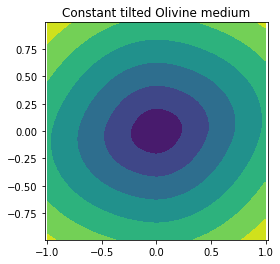

In [19]:
for name,hooke in zip(['Mica','Stishovite','Olivine'],[hooke1,hooke2,hooke3]):
    hfmIn_Constant['metric'] = HFMUtils.FlattenSymmetricMatrix(hooke)
    hfmOut = HFMUtils.Run(hfmIn_Constant)
    
    fig = plt.figure(figsize=[4,4]); plt.title("Constant tilted " + name + " medium"); plt.axis('equal')
    plt.contourf(X,Z,hfmOut['values']);
    
    if figSaveDir: fig.savefig(figSaveDir+"Distance_Constant"+name+".png")

## 2. Varying medium

### 2.1 Position dependent tilt orientation.

In [20]:
hfmIn_Varying = {
    'model':'Seismic2',
    'arrayOrdering':'YXZ_RowMajor',
    'exportValues':1,
    'seeds':[[0.,0.]],
    'tips':[[x,y] for y in HFMUtils.CenteredLinspace(-1,1,6) 
                    for x in HFMUtils.CenteredLinspace(-2,2,6)],
}

# Define the domain
n=201
hfmIn_Varying.update(HFMUtils.Rect(sides=[[-2,2],[-1,1]],dimx=n))

X,Z = HFMUtils.GetGrid(hfmIn_Varying)

In [21]:
# Make small oscillations in the tilting angle
tiltAngle = (np.pi/6.)*np.sin(np.pi*X+1)
hookeVar1 = Hooke2.Rotate(Hooke2.ExtractXZ(Hooke3.Mica / Hooke3.Mica_rho),tiltAngle)

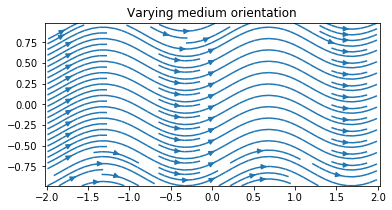

In [22]:
fig = plt.figure(figsize=[6,3]); plt.title("Varying medium orientation"); plt.axis('equal')
plt.streamplot(X,Z,np.cos(tiltAngle),np.sin(tiltAngle));

In [23]:
if figSaveDir: fig.savefig(figSaveDir+"Medium_MicaVaryingTilt.png")

In [24]:
# Transposition is to translate from 'Object of arrays' (Python) to 'Array of objects' (C++)
hookeVar = np.moveaxis(HFMUtils.FlattenSymmetricMatrix(hookeVar1),0,-1)

In [25]:
hfmIn_Varying['metric']=hookeVar

In [26]:
hfmOut = HFMUtils.Run(hfmIn_Varying)

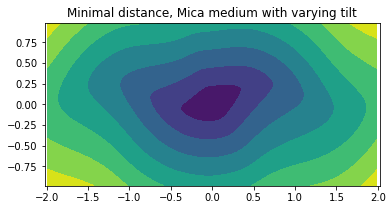

In [27]:
fig = plt.figure(figsize=[6,3]); plt.title('Minimal distance, Mica medium with varying tilt'); plt.axis('equal')
plt.contourf(X,Z,hfmOut['values']);

In [28]:
if figSaveDir: fig.savefig(figSaveDir+"Distance_MicaVaryingTilt.png")

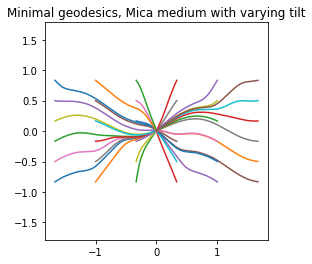

In [29]:
fig = plt.figure(figsize=[4,4]); plt.title('Minimal geodesics, Mica medium with varying tilt'); plt.axis('equal'); 
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 

### 2.2 Piecewise constant medium

In [31]:
#hookeVar2 = np.broadcast_to(hooke1.reshape((3,3,1,1)),hookeVar1.shape).copy()
#hookeVar2[:,:,X>(Z+0.3)] =hooke2 

## 3. Taking into account the topography

The arrival time of seismic waves is, usually, measured at ground level. In order to compute this quantity accurately, a good discretization of the surface topography may be required. 

However, the HFM software can only use rectangular domains, possibly with periodic boundary conditions. A change of variables toward the actual domain is this required, which jacobian matrix locally distorts the metric. Note that Hooke tensors do not define an class of metrics invariant under linear tranformations, as opposed to e.g. Riemannian, Rander, or asymmetric quadratic metrics, hence the jacobian matrix must be specified separately.

We limit our attention to changes of variables referred to as *topographic transformations*, taking the form
$$
    (x,z) \mapsto (x,z+h(x,z))
$$
and whose jacobian matrix is therefore
$$
    \begin{pmatrix}
        1 & 0 \\
        \partial_x h & 1+ \partial_z h
%        \frac{\partial h(x,y)}{\partial x} & 1+ \frac{\partial h(x,y)}{\partial y}
    \end{pmatrix}
$$



In [32]:
h_alpha = 0.5
def h(x,z): 
    return h_alpha*z*np.sin(np.pi*x)

def h_grad(x,z):
    return h_alpha*z*np.pi*np.cos(np.pi*x), h_alpha*np.sin(np.pi*x)

#Alternatively
#def h(x,z): return h_alpha*x
#def h_grad(x,z): return h_alpha+0.*x, 0.*x

Chosen physical domain is the image of the rectangle $[-1,1]\times [0,1]$ by the mapping $(x,z+h(x,z))$.

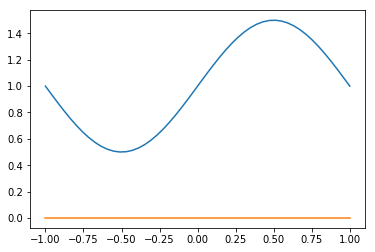

In [33]:
X = np.linspace(-1,1)
plt.plot(X,1+h(X,1),X,0+h(X,0));

In [34]:
hfmIn_Topo = {
    'model':'SeismicTopographic2',
    'arrayOrdering':'YXZ_RowMajor',
    'exportValues':1,
    'seeds':[[0.,0.5]],
    'tips':[[x,y] for y in HFMUtils.CenteredLinspace(0,1,6) 
                    for x in HFMUtils.CenteredLinspace(-1,1,6)],
}

# Define the domain
n=101
hfmIn_Topo.update(HFMUtils.Rect(sides=[[-1,1],[0,1]],dimx=n))

X0,Z0 = HFMUtils.GetGrid(hfmIn_Topo) # Rectangular coordinates
X,Z = X0, Z0+h(X0,Z0) # Physical coordinates
zero = 0*X

In [35]:
hooke = Hooke2.Rotate(Hooke2.ExtractXZ(Hooke3.Mica / Hooke3.Mica_rho),-np.pi/6+zero)

In [36]:
hfmIn_Topo['metric'] = np.transpose(np.stack([
    *HFMUtils.FlattenSymmetricMatrix(hooke), # Hooke tensor at X,Z (Physical coordinates)
    *h_grad(X0,Z0) # Height map gradient at X0,Z0 (Rectangular coordinates)
],axis=0),(1,2,0))

In [37]:
hfmOut = HFMUtils.Run(hfmIn_Topo)

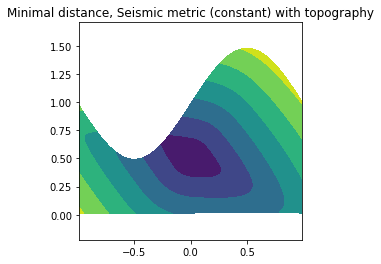

In [38]:
fig = plt.figure(figsize=[4,4]); plt.title('Minimal distance, Seismic metric (constant) with topography'); plt.axis('equal')
plt.contourf(X,Z,hfmOut['values']);

The geodesics are straight lines, except for those which would cross the surface.

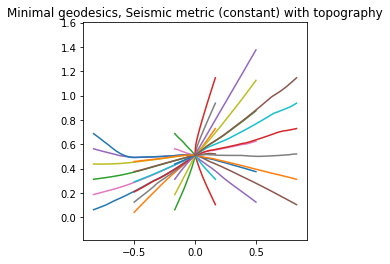

In [39]:
fig = plt.figure(figsize=[4,4]);  plt.axis('equal'); 
plt.title('Minimal geodesics, Seismic metric (constant) with topography');
for geo in HFMUtils.GetGeodesics(hfmOut):  
    plt.plot(geo[:,0],geo[:,1]+h(geo[:,0],geo[:,1])) 

Note that the computation involved a distorted metric, on a distorted domain.

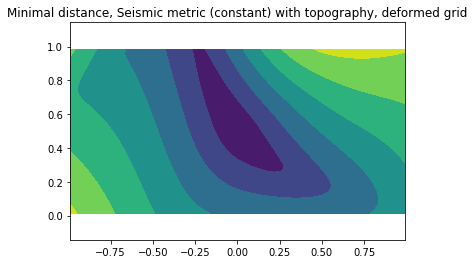

In [40]:
plt.title('Minimal distance, Seismic metric (constant) with topography, deformed grid'); plt.axis('equal')
plt.contourf(X0,Z0,hfmOut['values']);

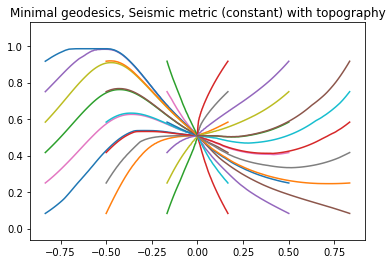

In [41]:
plt.title('Minimal geodesics, Seismic metric (constant) with topography'); plt.axis('equal'); 
for geo in HFMUtils.GetGeodesics(hfmOut):  
    plt.plot(geo[:,0],geo[:,1]) 

## 4. Testing reproduction

In this section, we check the soundness of the proposed discretization by comparing the numerical solution with the exact solution, when it is known.

### 4.1 Case of a constant metric

If the metric is constant and factorization is used over all the domain, then the exact solution is recovered, up to floating point accuracy.

In [42]:
n=101 # domain dimension along the x axis
hfmIn_Constant.update(HFMUtils.Rect(sides=[[-1,1],[-1,1]],dimx=n))
hfmIn_Constant.update({
    'factoringMethod':'Static',
    'factoringRadius':n, # factorization is used over all the domain 
})
X,Z = HFMUtils.GetGrid(hfmIn_Constant)

One can require the evaluation of the factor, which is here the exact solution, at specific locations.

In [43]:
hfmIn_Constant['factoringPoints'] = np.transpose(np.array([X.flatten(),Z.flatten()]))

In [44]:
hfmOut = HFMUtils.Run(hfmIn_Constant)

In [45]:
exact = hfmOut['factoringValues'].reshape(X.shape)

Exact and numerical solution match up to machine arithmetic precision.

In [46]:
np.max(np.abs(exact-hfmOut['values']))

8.326672684688674e-17

The fast marching algorithm, used under the hood, requires the numerical scheme to be causal, and therefore the stencils to be sufficiently refined. If this condition is not met, then a systematic error will occur.
For that purpose, the field *stencilGeometry* should be set to:
* 'None' (default), to produce adaptive stencils automatically obeying the causality property. (With some computational overhead.)
* 'Square', or 'SpikySquare', which are fine enough for the anisotropies encountered in seismology.

In the following example, we purposedly use an under-refined stencil, to illustrate inconsistencies in the lack of causality.

In [47]:
hfmIn_Constant['stencilGeometry']='Diamond' # This stencil is causal only for isotropic metrics

In [48]:
hfmOut = HFMUtils.Run(hfmIn_Constant)

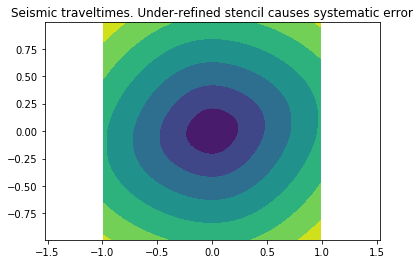

In [49]:
plt.title("Seismic traveltimes. Under-refined stencil causes systematic error"); plt.axis('equal')
plt.contourf(X,Z,hfmOut['values']);

In [50]:
hfmIn_Constant['stencilGeometry']='None' # Use automatically generated adaptive stencils (default)

### 4.2 Case with topography

In the instance involving ground topography, the discretization grid is distorted. Therefore the numerical metric is non-constant, and we cannot expect the numerical method to exactly reproduce the arrival times. 
We compute the exact arrival times as above, by requiring the factor used in the constant case.

In [51]:
X0,Z0 = HFMUtils.GetGrid(hfmIn_Topo) # Rectangular coordinates
X,Z = X0, Z0+h(X0,Z0) # Physical coordinates

In [52]:
hfmIn_Constant.update({
    'factoringPoints':np.transpose(np.array([X.flatten(),Z.flatten()])),
    'metric':hfmIn_Topo['metric'][0,0,:6],
    'seeds':[[0,0.5]]
})

In [53]:
hfmOut = HFMUtils.Run(hfmIn_Constant)

In [54]:
exact = hfmOut['factoringValues'].reshape(X.shape)

We introduce source factorization so as to reduce the numerical error of the numerical method. 

In [55]:
hfmIn_Topo.update({
    'factoringMethod':'Static',
    'factoringRadius':101 # factorization is used over all the domain 
})

In [56]:
hfmOut = HFMUtils.Run(hfmIn_Topo)

In [57]:
error = exact-hfmOut['values']

Actually, our 'exact' solution is only exact outside the shadow zone, in the upper left part of the domain, which is not connected to the seed by a straight line in the domain.

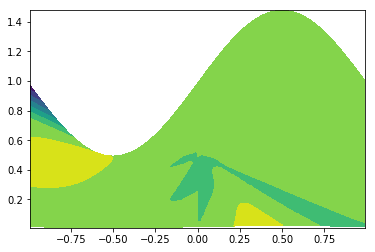

In [58]:
plt.contourf(X,Z,error);

In [59]:
shadowRegion = np.logical_and(X<=-0.4, Z>=0.4)
print("Numerical error outside shadow region : ", np.max(np.abs(error * (1-shadowRegion))))
print("Time difference inside shadow region : ", np.max(np.abs(error*shadowRegion)))

Numerical error outside shadow region :  0.016643417575545133
Time difference inside shadow region :  0.057694598197075925


## 4. Three dimensional example

We illustrate the computation of three dimensional seismic wave traveltimes.

### 4.1 Case of a constant metric

The geological medium is defined as tilted mica.

In [60]:
# Define a rotation matrix by its axis and angle
rotation = Hooke3.RotationMatrix((1,2,3),np.pi/3)
hooke3D_1 = Hooke3.Rotate(Hooke3.Mica,rotation)
hooke3D_2 = Hooke3.Rotate(Hooke3.Olivine,rotation) 

In [61]:
hfmIn3D_Constant = {
    'model':'Seismic3',    
    'metric':HFMUtils.FlattenSymmetricMatrix(hooke3D_1),
    'seeds':[[0.,0.,0.]],

    'factoringMethod':'Static',
    'factoringRadius':8,

    'arrayOrdering':'RowMajor',
    'exportValues':1,
}

# Define the domain
n=20; nHalf = n//2
hfmIn3D_Constant.update(HFMUtils.Rect(sides=[[-1,1],[-1,1],[-1,1]],dimx=n))

At the time of writing, the *Seismic3* model does not support an adaptive stencil construction, automatically enforcing the causality property. The *stencil geometry* must therefore be explicitly defined, chosen among the following possibilities:
* **CutCube** uses $18$ neighbors. Causal for moderately anisotropic models, such as olivine or stishovite.
* **Cube** uses $26$ neighbors. Intermediate refinement.
* **SpikyCube** uses $50$ neighbors. Causal for the mica medium, which is one of the most strongly anisotropic encountered in seismology.

The numerical cost of the fast marching method is directly impacted by the numeber of neighbors used.

In [62]:
hfmIn3D_Constant['stencilGeometry']='SpikyCube' # Largest stencil, suitable for mica (strong anisotropy)

In [63]:
X,Y,Z = HFMUtils.GetGrid(hfmIn3D_Constant)
hfmIn3D_Constant['factoringPoints']=np.transpose(np.array([X.flatten(),Y.flatten(),Z.flatten()]))

In [64]:
hfmOut = HFMUtils.Run(hfmIn3D_Constant)

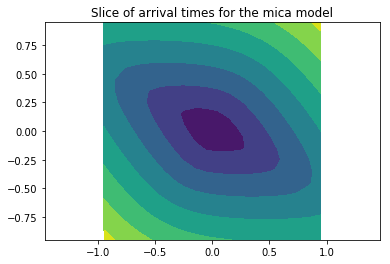

In [66]:
plt.axis('equal'); plt.title('Slice of arrival times for the mica model')
plt.contourf(Y[nHalf,:,:],Z[nHalf,:,:],hfmOut['values'][nHalf,:,:]);

In [67]:
exact = hfmOut['factoringValues'].reshape(X.shape)
error = hfmOut['values']-exact
factoringRegion = np.sqrt(X**2+Y**2+Z**2) < 0.7*hfmIn3D_Constant['factoringRadius']*hfmIn3D_Constant['gridScale']
# TODO : check why 0.7 needed

Because the metric is constant, the arrival times are exact in the factoring region.
A small error is omitted elsewhere. Usage of higher order schemes will further decrease it.

In [68]:
print("Error in factoring region : ",np.max(np.abs(error * factoringRegion)))
print("Global error : ", np.max(np.abs(error)))

Error in factoring region :  5.551115123125783e-17
Global error :  0.002892265137726252


In [69]:
#def sisnorm(p):
#    ind = np.array(p)+nHalf
#    ex,nu = exact[ind[0],ind[1],ind[2]],hfmOut['values'][ind[0],ind[1],ind[2]]
#    return nu-ex,ex,nu

The less anisotropic olivine model can accomodate less refined stencils, and enjoy faster computation times.

In [70]:
hfmIn3D_Constant.update({
    'metric':HFMUtils.FlattenSymmetricMatrix(hooke3D_2),
    'stencilGeometry':'CutCube',
})

In [71]:
hfmOut = HFMUtils.Run(hfmIn3D_Constant)

In [72]:
print(hfmOut['FMCPUTime'])

0.531554


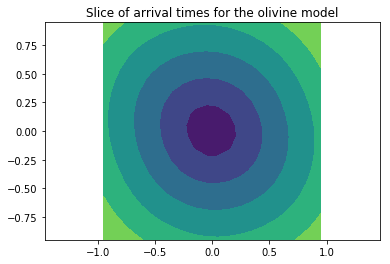

In [73]:
plt.axis('equal'); plt.title('Slice of arrival times for the olivine model')
plt.contourf(Y[nHalf,:,:],Z[nHalf,:,:],hfmOut['values'][nHalf,:,:]);

In [74]:
exact = hfmOut['factoringValues'].reshape(X.shape)
error = hfmOut['values']-exact
print("Error in factoring region : ",np.max(np.abs(error * factoringRegion)))
print("Global error : ", np.max(np.abs(error)))

Error in factoring region :  2.7755575615628914e-17
Global error :  0.002671223989547264


Similarly to the two dimensional case, using insufficiently refined stencils breaks the numerical method consistency, and yields inconsistent results.

In [75]:
hfmIn3D_Constant.update({
    'metric':HFMUtils.FlattenSymmetricMatrix(hooke3D_1),
    'stencilGeometry':'CutCube', # Also fails with 'Cube'
})


In [76]:
hfmOut = HFMUtils.Run(hfmIn3D_Constant)

In [77]:
exact = hfmOut['factoringValues'].reshape(X.shape)
error = hfmOut['values']-exact
print("Error in factoring region (non-zero due to insufficient refinement): ",np.max(np.abs(error * factoringRegion)))
print("Global error : ", np.max(np.abs(error)))

Error in factoring region (non-zero due to insufficient refinement):  0.0004141834580693726
Global error :  0.008586903071343965


### 4.2 Position dependent metric

In [78]:
hfmIn3D_Varying = {
    'model':'Seismic3', 
    'arrayOrdering':'RowMajor',
    'exportValues':1,
    'seeds':[[0.,0.,0.5]],
    'factoringMethod':'Static',
    'factoringRadius':7,
    'stencilGeometry':'SpikyCube',
    'order':2
}

# Define the domain
n=30; 
hfmIn3D_Varying.update(HFMUtils.Rect(sides=[[-1,1],[-1,1],[0,1]],dimx=n))

In [79]:
X,Y,Z = HFMUtils.GetGrid(hfmIn3D_Varying)

In [80]:
z=np.zeros(X.shape)
rotation1 = Hooke3.RotationMatrix( (1+z,z,z), (np.pi/6)*np.sin(2*np.pi*(X+0.4)))
rotation2 = Hooke3.RotationMatrix( (z,1+z,z), (np.pi/6)*np.sin(2*np.pi*(Y-0.7)))
rotation = lp.dot_AA(rotation1,rotation2)

In [81]:
hooke3D_3 = Hooke3.Rotate(Hooke3.Mica,rotation)

In [82]:
hfmIn3D_Varying['metric'] = np.transpose(HFMUtils.FlattenSymmetricMatrix(hooke3D_3),(1,2,3,0))
#hfmIn3D_Varying['metric'] = HFMUtils.FlattenSymmetricMatrix(Hooke3.Mica)

In [83]:
hfmOut = HFMUtils.Run(hfmIn3D_Varying)

In [84]:
#print(hfmOut['log'])

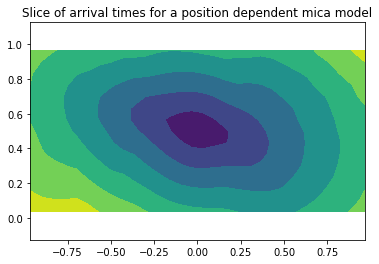

In [85]:
nHalf=n//2
plt.axis('equal'); plt.title('Slice of arrival times for a position dependent mica model')
plt.contourf(Y[nHalf,:,:],Z[nHalf,:,:],hfmOut['values'][nHalf,:,:]);

### 4.3 Topography

$$
    (x,y,z) \mapsto (x,y,z+h(x,y,z))
$$

In [86]:
h_alpha = 0.3
def h(x,y,z): 
    return h_alpha*z*np.sin(np.pi*x)*np.cos(np.pi*y)

def h_grad(x,y,z):
    return (h_alpha*z*np.pi*np.cos(np.pi*x)*np.cos(np.pi*y), 
            -h_alpha*z*np.pi*np.sin(np.pi*x)*np.sin(np.pi*y), 
            h_alpha*np.sin(np.pi*x)*np.cos(np.pi*y) )

In [87]:
hfmIn3D_Topo = {
    'order':2,
    'model':'SeismicTopographic3',
    'arrayOrdering':'RowMajor',
    'exportValues':1,
    'seeds':[[0.,0.,0.5]],
    'stencilGeometry':'Cube'
}

# Define the domain
n=40
hfmIn3D_Topo.update(HFMUtils.Rect(sides=[[-1,1],[-1,1],[0,1]],dimx=n))

X0,Y0,Z0 = HFMUtils.GetGrid(hfmIn3D_Topo) # Rectangular coordinates
X,Y,Z = X0,Y0,Z0+h(X0,Y0,Z0) # Physical coordinates

In [88]:
z = 0*X
hooke = Hooke3.Rotate(Hooke3.Stishovite,Hooke3.RotationMatrix((1+z,2+z,3+z),-np.pi/6+z))

In [89]:
hfmIn3D_Topo['metric'] = np.transpose(np.stack([
    *HFMUtils.FlattenSymmetricMatrix(hooke), # Hooke tensor at X,Z (Physical coordinates)
    *h_grad(X0,Y0,Z0) # Height map gradient at X0,Z0 (Rectangular coordinates)
],axis=0),(1,2,3,0))

In [90]:
hfmOut = HFMUtils.Run(hfmIn3D_Topo)

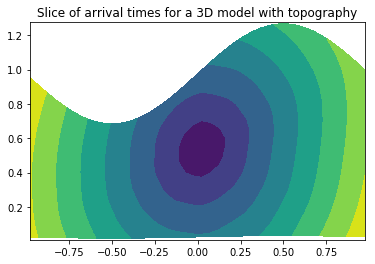

In [91]:
nHalf=n//2
plt.axis('equal'); plt.title('Slice of arrival times for a 3D model with topography')
plt.contourf(X[:,nHalf,:],Z[:,nHalf,:],hfmOut['values'][:,nHalf,:]);